# MBA em Ciência de Dados - TCC
# Predição da Radiação Solar para Produção de Hidrogênio Verde: Análise comparativa de métodos de Aprendizado de Máquina

## Resultados - Visualização
**Material Produzido por:** Mateus Vasconcelos Albuquerque

**Cemeai - ICMC/USP São Carlos**


---------------------------------------------------------------------------------------------------------





In [ ]:
from google.colab import drive
import os

# Monta o Google Drive
drive.mount('/content/drive')

# Define o caminho da pasta 'Projetos'
projetos_path = '/content/drive/My Drive/MBA/TCC/Projeto'

# Define o diretório de trabalho para a pasta 'Projetos'
if os.path.exists(projetos_path):
    os.chdir(projetos_path)
    print(f"Diretório alterado para: {projetos_path}")
else:
    print(f"A pasta 'Projetos' não foi encontrada em: {projetos_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Diretório alterado para: /content/drive/My Drive/MBA/TCC/Projeto


In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

In [ ]:
# 📌 1. CARREGAR MODELOS DO REPOSITÓRIO output_forecast/
models = {
    "SVR": joblib.load("output_forecast/svr_random_search_model.joblib"),
    "RandomForest": joblib.load("output_forecast/random_forest_random_search_model.joblib"),
    "XGBoost": joblib.load("output_forecast/xgb_random_search_model.joblib"),
    "LSTM": load_model("output_forecast/lstm_random_search.keras")
}

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.6.0 when using version 1.6.1. This might lead to breaking code 

In [ ]:
# 📌 2. SALVAR HIPERPARÂMETROS EM UM DICIONÁRIO
hyperparameters = {}
for model_name, model in models.items():
    if model_name == "RandomForest":
        best_params = {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100}
        hyperparameters[model_name] = best_params
    elif model_name == "XGBoost":
        best_params = {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
        hyperparameters[model_name] = best_params
    elif hasattr(model, 'get_params'):
        hyperparameters[model_name] = model.get_params()
    elif model_name == 'LSTM':
        # Definindo os hiperparâmetros manualmente para o LSTM
        best_params = {
            'neurons': 32,
            'learning_rate': 0.001,
            'layers': 2,
            'dropout': 0.2,
            'epochs': 50,
            'batch_size': 32
        }
        hyperparameters[model_name] = best_params
    else:
        hyperparameters[model_name] = "Hiperparâmetros não disponíveis"

# Exibindo os hiperparâmetros
for model_name, params in hyperparameters.items():
    print(f"Hiperparâmetros do {model_name}: {params}")


Hiperparâmetros do SVR: {'C': 10, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.001, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Hiperparâmetros do RandomForest: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100}
Hiperparâmetros do XGBoost: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Hiperparâmetros do LSTM: {'neurons': 32, 'learning_rate': 0.001, 'layers': 2, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [ ]:
# 📌 3. FUNÇÃO PARA CRIAR O MODELO LSTM
def lstm_model(X_train, neurons=50, layers=1, dropout=0.2, learning_rate=0.001):
    model = Sequential()
    for i in range(layers):
        return_sequences = i < layers - 1  # Retorna sequências até a penúltima camada
        # Definindo o input_shape somente na primeira camada
        if i == 0:
            model.add(LSTM(neurons, return_sequences=return_sequences, input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(LSTM(neurons, return_sequences=return_sequences))
        model.add(Dropout(dropout))
    model.add(Dense(1))  # Camada de saída
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

In [ ]:
# 📌 4. CARREGAR DADOS TREINAMENTO & TESTE
X_tr_top = pd.read_csv("output_forecast/X_tr_top.csv", index_col=0)
X_ts_top = pd.read_csv("output_forecast/X_ts_top.csv", index_col=0)
Y_tr_scaled = pd.read_csv("output_forecast/Y_tr_scaled.csv", index_col=0).values.ravel()
Y_ts_scaled = pd.read_csv("output_forecast/Y_ts_scaled.csv", index_col=0).values.ravel()

scaler_X = joblib.load("output_forecast/scaler.joblib")
scaler_Y = joblib.load("output_forecast/scaler_y.joblib")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# show all columns
pd.set_option('display.max_columns', None)

In [ ]:
# 📌 5. CARREGAR DADOS PARA O LSTM
X_train_lstm = np.load("output_forecast/X_train_lstm.npy")
X_test_lstm = np.load("output_forecast/X_test_lstm.npy")
y_train_lstm = np.load("output_forecast/y_train_lstm.npy")
y_test_lstm = np.load("output_forecast/y_test_lstm.npy")

scaler_X_lstm = joblib.load("output_forecast/scaler_X_lstm.joblib")
scaler_Y_lstm = joblib.load("output_forecast/scaler_y_lstm.joblib")

In [ ]:
# Convertendo o índice para datetime, se necessário
X_tr_top.index = pd.to_datetime(X_tr_top.index)
X_ts_top.index = pd.to_datetime(X_ts_top.index)

In [ ]:
# 📌 4. INSTANTIAR OS MODELOS COM OS MELHORES PARÂMETROS

# 1. SVR
svr_model = SVR(C=hyperparameters['SVR']['C'], epsilon=hyperparameters['SVR']['epsilon'], kernel=hyperparameters['SVR']['kernel'])

# 2. Random Forest
random_forest_best_parameters = hyperparameters['RandomForest']
print(random_forest_best_parameters)
# random_forest_model = RandomForestRegressor(**random_forest_best_parameters)
random_forest_model = RandomForestRegressor(
    n_estimators=hyperparameters['RandomForest']['n_estimators'],
    max_depth=hyperparameters['RandomForest']['max_depth'],
    max_features=hyperparameters['RandomForest']['max_features'],
    min_samples_split=hyperparameters['RandomForest']['min_samples_split'],
    min_samples_leaf=hyperparameters['RandomForest']['min_samples_leaf']
)

# 3. XGBoost
xgboost_model = xgb.XGBRegressor(learning_rate=hyperparameters['XGBoost']['learning_rate'],
                                 n_estimators=hyperparameters['XGBoost']['n_estimators'],
                                 max_depth=hyperparameters['XGBoost']['max_depth'],
                                 subsample=hyperparameters['XGBoost']['subsample'],
                                 colsample_bytree=hyperparameters['XGBoost']['colsample_bytree'],
                                 min_child_weight=hyperparameters['XGBoost']['min_child_weight'],
                                 reg_lambda=hyperparameters['XGBoost']['reg_lambda'],
                                 reg_alpha=hyperparameters['XGBoost']['reg_alpha'],
                                 gamma=hyperparameters['XGBoost']['gamma']
                                 )

# 4. LSTM

# Instanciando o modelo LSTM
lstm_model_instance = lstm_model(X_train_lstm, neurons=hyperparameters['LSTM']['neurons'],
                                 layers=hyperparameters['LSTM']['layers'], dropout=hyperparameters['LSTM']['dropout'],
                                 learning_rate=hyperparameters['LSTM']['learning_rate'])

# 📌 EXIBIR OS MODELOS INSTANCIADOS
print("Modelos instanciados:")
print(f"SVR: {svr_model}")
print(f"Random Forest: {random_forest_model}")
# Imprime os parâmetros configurados do modelo
print(f"Random Forest parâmetros: {random_forest_model.get_params()}")
print(f"XGBoost: {xgboost_model}")
print(f"LSTM: {lstm_model_instance.summary()}")

instance_models = {
    "SVR": svr_model,
    "RandomForest": random_forest_model,
    "XGBoost": xgboost_model
}

{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelos instanciados:
SVR: SVR(C=10, epsilon=0.001)
Random Forest: RandomForestRegressor(max_depth=100, max_features='sqrt', n_estimators=1000)
Random Forest parâmetros: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 100, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
XGBoost: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
       

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 32)              │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,473 (52.63 KB)

 Trainable params: 13,473 (52.63 KB)

 Non-trainable params: 0 (0.00 B)

LSTM: None


In [ ]:
# tscv = TimeSeriesSplit(n_splits=3)
# results = {name: {'mae': [], 'rmse': [], 'r2': []} for name in models.keys()}

# # Iterando pelos folds da validação cruzada
# for fold, (train_idx, test_idx) in enumerate(tscv.split(X_tr_top), 1):
#     print(f"Fold {fold}/{tscv.get_n_splits()}")

#     X_train, X_test = X_tr_top.iloc[train_idx], X_tr_top.iloc[test_idx]
#     y_train, y_test = Y_tr_scaled[train_idx], Y_tr_scaled[test_idx]

#     # Iterando pelos modelos
#     for name, model in models.items():
#         print(f" Treinando o modelo {name}...")

#         # if name == "LSTM":
#         #     X_train_lstm_cv, X_test_lstm_cv = X_train_lstm[train_idx], X_train_lstm[test_idx]
#         #     y_train_lstm_cv, y_test_lstm_cv = y_train_lstm[train_idx], y_train_lstm[test_idx]

#         #     model.fit(X_train_lstm_cv, y_train_lstm_cv, epochs=hyperparameters["LSTM"]["epochs"], batch_size=hyperparameters["LSTM"]["batch_size"], verbose=2)
#         #     y_pred = model.predict(X_test_lstm_cv)
#         #     y_pred = scaler_Y_lstm.inverse_transform(y_pred)
#         #     y_test = scaler_Y_lstm.inverse_transform(y_test_lstm_cv)
#         if name == "LSTM":
#             # Criando uma nova instância do modelo LSTM antes de cada fold
#             lstm_model_instance = lstm_model(
#                 X_train_lstm,
#                 neurons=hyperparameters["LSTM"]["neurons"],
#                 layers=hyperparameters["LSTM"]["layers"],
#                 dropout=hyperparameters["LSTM"]["dropout"],
#                 learning_rate=hyperparameters["LSTM"]["learning_rate"]
#             )

#             # Treinando o modelo LSTM
#             X_train_lstm_cv, X_test_lstm_cv = X_train_lstm[train_idx], X_train_lstm[test_idx]
#             y_train_lstm_cv, y_test_lstm_cv = y_train_lstm[train_idx], y_train_lstm[test_idx]

#             lstm_model_instance.fit(X_train_lstm_cv, y_train_lstm_cv, epochs=hyperparameters["LSTM"]["epochs"], batch_size=hyperparameters["LSTM"]["batch_size"], verbose=2)
#             y_pred = lstm_model_instance.predict(X_test_lstm_cv)
#             y_pred = scaler_Y_lstm.inverse_transform(y_pred)
#             y_test = scaler_Y_lstm.inverse_transform(y_test_lstm_cv)
#         else:
#             model.fit(X_train, y_train)
#             y_pred = model.predict(X_test)
#             y_pred = scaler_Y.inverse_transform(y_pred.reshape(-1, 1))
#             y_test = scaler_Y.inverse_transform(y_test.reshape(-1, 1))

#         # Calculando as métricas
#         mae = mean_absolute_error(y_test, y_pred)
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         r2 = r2_score(y_test, y_pred)

#         # Adicionando os resultados para cada modelo
#         results[name]['mae'].append(mae)
#         results[name]['rmse'].append(rmse)
#         results[name]['r2'].append(r2)

#         # Exibindo resultados parciais do modelo
#         print(f"  Modelo {name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# # Exibindo os resultados finais
# print("\nResultados Finais:")
# for name, metrics in results.items():
#     print(f"\nModelo {name}:")
#     print(f" MAE médio: {np.mean(metrics['mae']):.4f}")
#     print(f" RMSE médio: {np.mean(metrics['rmse']):.4f}")
#     print(f" R2 médio: {np.mean(metrics['r2']):.4f}")

# Random Forest

In [ ]:
# # 📌 a. Treinar o modelo
random_forest_model.fit(X_tr_top, Y_tr_scaled)

RandomForestRegressor(max_depth=100, max_features='sqrt', n_estimators=1000)

In [ ]:
# random_forest_model = models["RandomForest"]

In [ ]:
# 📌 b. Fazer previsões
y_pred_rf = random_forest_model.predict(X_ts_top)

In [ ]:
# 📌 c. Inverter o Min-Max Scaling
y_pred_inversed_rf = scaler_Y.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()
y_test_inversed_rf = scaler_Y.inverse_transform(Y_ts_scaled.reshape(-1, 1)).ravel()
# y_pred_inversed_rf = scaler_Y_lstm.inverse_transform(y_pred_rf)
# y_test_inversed_rf = scaler_Y_lstm.inverse_transform(Y_ts_scaled)

In [ ]:
# 📌 d. Calcular as métricas
mae_rf = mean_absolute_error(y_test_inversed_rf, y_pred_inversed_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_inversed_rf, y_pred_inversed_rf))
r2_rf = r2_score(y_test_inversed_rf, y_pred_inversed_rf)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}")

Random Forest - MAE: 133.8911, RMSE: 261.0716, R²: 0.9461


In [ ]:
# Converter o array em Series com o mesmo índice de X_ts_top
y_test_inv_series_rf = pd.Series(y_test_inversed_rf.flatten(), index=X_ts_top.index)
y_pred_inv_series_rf = pd.Series(y_pred_inversed_rf.flatten(), index=X_ts_top.index)

In [ ]:
# Transformação em Qtde de H2 produzida
eta_fv = 0.22
eta_pc = 0.85

E_fv_test = y_test_inv_series_rf * eta_fv * eta_pc   # Energia produzida em kJ/m2
E_fv_pred = y_pred_inv_series_rf * eta_fv * eta_pc   # Energia produzida em kJ/m2

eta_ele = 0.755
hhv_h2 = 285.83   # kJ/mol

n_h2_test = E_fv_test * eta_ele / hhv_h2   # kJ/m2 * mol / kJ ==> mol/m2
n_h2_pred = E_fv_pred * eta_ele / hhv_h2   # mol/m2


In [ ]:
# 📌 Calcular as métricas em unidade de H2 produzido
mae_h2_rf = mean_absolute_error(n_h2_test, n_h2_pred)
rmse_h2_rf = np.sqrt(mean_squared_error(n_h2_test, n_h2_pred))
r2_h2_rf = r2_score(n_h2_test, n_h2_pred)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_h2_rf:.4f}, RMSE: {rmse_h2_rf:.4f}, R²: {r2_h2_rf:.4f}")

Random Forest - MAE: 0.0661, RMSE: 0.1290, R²: 0.9461


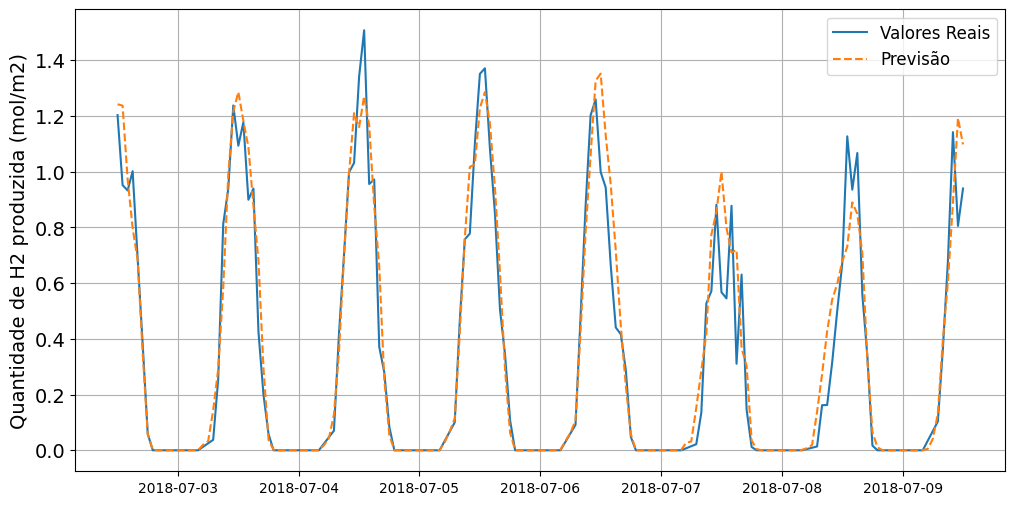

In [ ]:
# 📈 5. Plotar gráfico
# 7 dias
obs = 24 * 7

plt.figure(figsize=(12, 6))
plt.plot(n_h2_test[:obs+1], label='Valores Reais')
plt.plot(n_h2_pred[:obs+1], "--", label='Previsão')
# plt.title('Valores Reais vs Previsões (Random Forest)')
# plt.xlabel('Observações')
plt.ylabel('Quantidade de H2 produzida (mol/m2)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

In [ ]:
import seaborn as sns

# Calcular o R²
r2_rf_h2 = r2_score(n_h2_test, n_h2_pred)

# Criar o gráfico de dispersão
plt.figure(figsize=(8, 8))
# sns.scatterplot(x=n_h2_test, y=n_h2_pred, s=50, color='blue', edgecolor='k')
sns.scatterplot(x=n_h2_test, y=n_h2_pred, s=50, edgecolor='k')

# Linha de referência (y = x)
max_val = max(max(n_h2_test), max(n_h2_pred))
min_val = min(min(n_h2_test), min(n_h2_pred))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='darkred', linewidth=2, label='Ideal (y = x)')

# Personalização
plt.xlabel('Valores Reais (mol/m²)', fontsize=14)
plt.ylabel('Valores Previstos (mol/m²)', fontsize=14)
plt.title(f'R² = {r2_rf_h2:.2f}', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

NameError: name 'r2_score' is not defined

# SVR

In [ ]:
# 📌 a. Load do modelo
# svr_model.fit(X_tr_top, Y_tr_scaled)
svr_model = models["SVR"]

In [ ]:
# 📌 b. Fazer previsões
y_pred_svr = svr_model.predict(X_ts_top)

In [ ]:
# 📌 c. Inverter o Min-Max Scaling
y_pred_inversed_svr = scaler_Y.inverse_transform(y_pred_svr.reshape(-1, 1)).ravel()
y_test_inversed_svr = scaler_Y.inverse_transform(Y_ts_scaled.reshape(-1, 1)).ravel()
# y_pred_inversed_rf = scaler_Y_lstm.inverse_transform(y_pred_rf)
# y_test_inversed_rf = scaler_Y_lstm.inverse_transform(Y_ts_scaled)

In [ ]:
# 📌 d. Calcular as métricas
mae_svr = mean_absolute_error(y_test_inversed_svr, y_pred_inversed_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test_inversed_svr, y_pred_inversed_svr))
r2_svr = r2_score(y_test_inversed_svr, y_pred_inversed_svr)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_svr:.4f}, RMSE: {rmse_svr:.4f}, R²: {r2_svr:.4f}")

Random Forest - MAE: 135.6132, RMSE: 266.7414, R²: 0.9437


In [ ]:
# Converter o array em Series com o mesmo índice de X_ts_top
y_test_inv_series_svr = pd.Series(y_test_inversed_svr.flatten(), index=X_ts_top.index)
y_pred_inv_series_svr = pd.Series(y_pred_inversed_svr.flatten(), index=X_ts_top.index)

In [ ]:
# Transformação em Qtde de H2 produzida
eta_fv = 0.22
eta_pc = 0.85

eta_ele = 0.755
hhv_h2 = 285.83   # kJ/mol

E_fv_test_svr = y_test_inv_series_svr * eta_fv * eta_pc   # Energia produzida em kJ/m2
E_fv_pred_svr = y_pred_inv_series_svr * eta_fv * eta_pc   # Energia produzida em kJ/m2

n_h2_test_svr = E_fv_test_svr * eta_ele / hhv_h2   # kJ/m2 * mol / kJ ==> mol/m2
n_h2_pred_svr = E_fv_pred_svr * eta_ele / hhv_h2   # mol/m2

In [ ]:
# 📌 Calcular as métricas em unidade de H2 produzido
mae_h2_svr = mean_absolute_error(n_h2_test_svr, n_h2_pred_svr)
rmse_h2_svr = np.sqrt(mean_squared_error(n_h2_test_svr, n_h2_pred_svr))
r2_h2_svr = r2_score(n_h2_test_svr, n_h2_pred_svr)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_h2_svr:.4f}, RMSE_svr: {rmse_h2_svr:.4f}, R²: {r2_h2_svr:.4f}")

Random Forest - MAE: 0.0670, RMSE_svr: 0.1318, R²: 0.9437


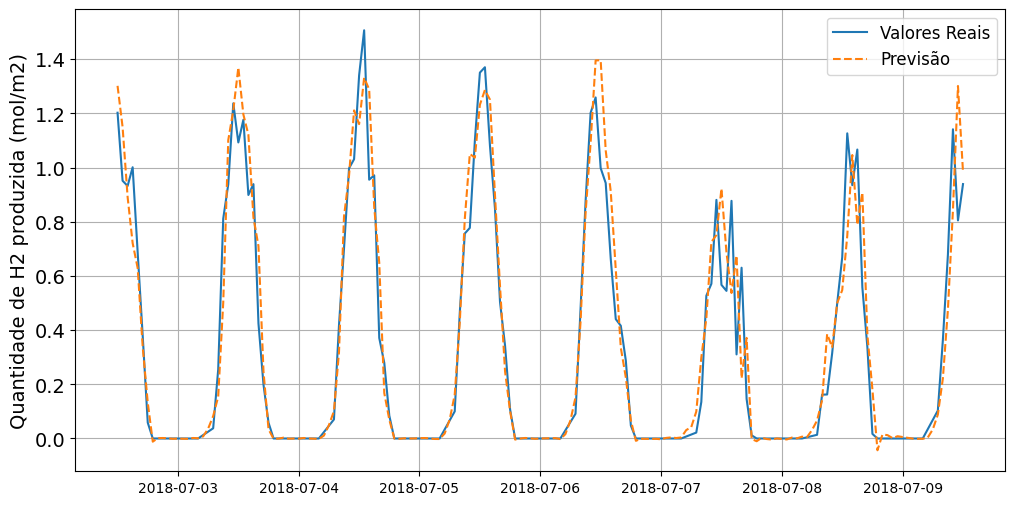

In [ ]:
# 📈 5. Plotar gráfico
# 7 dias
obs = 24 * 7

plt.figure(figsize=(12, 6))
plt.plot(n_h2_test_svr[:obs+1], label='Valores Reais')
plt.plot(n_h2_pred_svr[:obs+1], "--", label='Previsão')
# plt.title('Valores Reais vs Previsões (Random Forest)')
# plt.xlabel('Observações')
plt.ylabel('Quantidade de H2 produzida (mol/m2)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

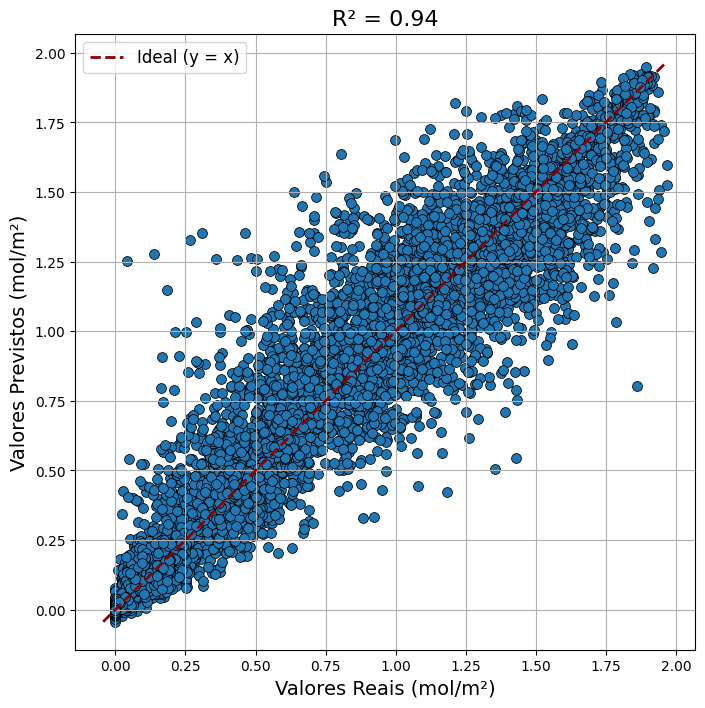

In [ ]:
import seaborn as sns

# Calcular o R²
r2_h2_svr = r2_score(n_h2_test_svr, n_h2_pred_svr)

# Criar o gráfico de dispersão
plt.figure(figsize=(8, 8))
# sns.scatterplot(x=n_h2_test, y=n_h2_pred, s=50, color='blue', edgecolor='k')
sns.scatterplot(x=n_h2_test_svr, y=n_h2_pred_svr, s=50, edgecolor='k')

# Linha de referência (y = x)
max_val = max(max(n_h2_test_svr), max(n_h2_pred_svr))
min_val = min(min(n_h2_test_svr), min(n_h2_pred_svr))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='darkred', linewidth=2, label='Ideal (y = x)')

# Personalização
plt.xlabel('Valores Reais (mol/m²)', fontsize=14)
plt.ylabel('Valores Previstos (mol/m²)', fontsize=14)
plt.title(f'R² = {r2_h2_svr:.2f}', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# XGBoost

In [ ]:
# 📌 a. Load do modelo
# xgboost_model.fit(X_tr_top, Y_tr_scaled)
xgboost_model = models["XGBoost"]

In [ ]:
# 📌 b. Fazer previsões
y_pred_xgboost = xgboost_model.predict(X_ts_top)

In [ ]:
# 📌 c. Inverter o Min-Max Scaling
y_pred_inversed_xgboost = scaler_Y.inverse_transform(y_pred_xgboost.reshape(-1, 1)).ravel()
y_test_inversed_xgboost = scaler_Y.inverse_transform(Y_ts_scaled.reshape(-1, 1)).ravel()
# y_pred_inversed_rf = scaler_Y_lstm.inverse_transform(y_pred_rf)
# y_test_inversed_rf = scaler_Y_lstm.inverse_transform(Y_ts_scaled)

In [ ]:
# 📌 d. Calcular as métricas
mae_xgboost = mean_absolute_error(y_test_inversed_xgboost, y_pred_inversed_xgboost)
rmse_xgboost = np.sqrt(mean_squared_error(y_test_inversed_xgboost, y_pred_inversed_xgboost))
r2_xgboost = r2_score(y_test_inversed_xgboost, y_pred_inversed_xgboost)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_xgboost:.4f}, RMSE: {rmse_xgboost:.4f}, R²: {r2_xgboost:.4f}")

Random Forest - MAE: 131.5778, RMSE: 261.9086, R²: 0.9458


In [ ]:
# Converter o array em Series com o mesmo índice de X_ts_top
y_test_inv_series_xgboost = pd.Series(y_test_inversed_xgboost.flatten(), index=X_ts_top.index)
y_pred_inv_series_xgboost = pd.Series(y_pred_inversed_xgboost.flatten(), index=X_ts_top.index)

In [ ]:
# Transformação em Qtde de H2 produzida
eta_fv = 0.22
eta_pc = 0.85

eta_ele = 0.755
hhv_h2 = 285.83   # kJ/mol

E_fv_test_xgboost = y_test_inv_series_xgboost * eta_fv * eta_pc   # Energia produzida em kJ/m2
E_fv_pred_xgboost = y_pred_inv_series_xgboost * eta_fv * eta_pc   # Energia produzida em kJ/m2

n_h2_test_xgboost = E_fv_test_xgboost * eta_ele / hhv_h2   # kJ/m2 * mol / kJ ==> mol/m2
n_h2_pred_xgboost = E_fv_pred_xgboost * eta_ele / hhv_h2   # mol/m2

In [ ]:
# 📌 Calcular as métricas em unidade de H2 produzido
mae_h2_xgboost = mean_absolute_error(n_h2_test_xgboost, n_h2_pred_xgboost)
rmse_h2_xgboost = np.sqrt(mean_squared_error(n_h2_test_xgboost, n_h2_pred_xgboost))
r2_h2_xgboost = r2_score(n_h2_test_xgboost, n_h2_pred_xgboost)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_h2_xgboost:.4f}, RMSE_svr: {rmse_h2_xgboost:.4f}, R²: {r2_h2_xgboost:.4f}")

Random Forest - MAE: 0.0650, RMSE_svr: 0.1294, R²: 0.9458


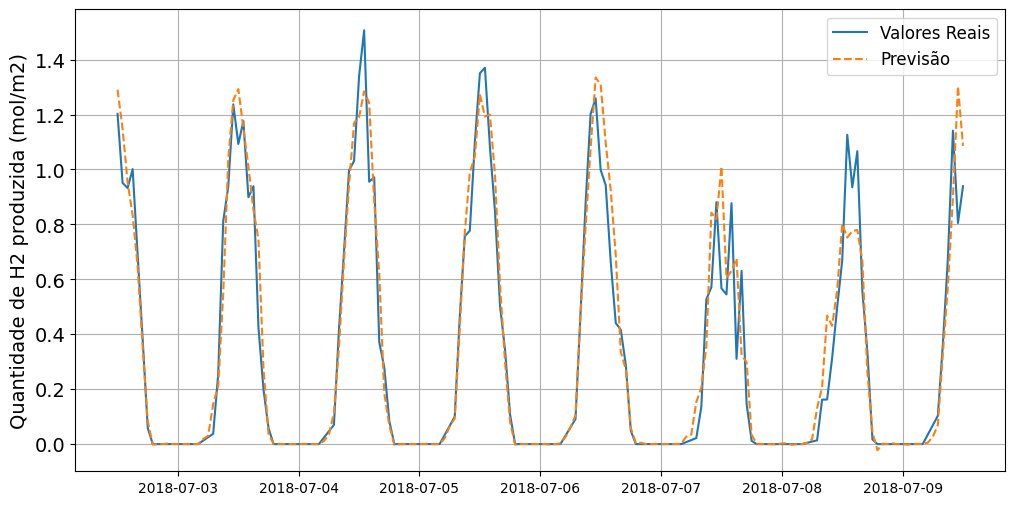

In [ ]:
# 📈 5. Plotar gráfico
# 7 dias
obs = 24 * 7

plt.figure(figsize=(12, 6))
plt.plot(n_h2_test_xgboost[:obs+1], label='Valores Reais')
plt.plot(n_h2_pred_xgboost[:obs+1], "--", label='Previsão')
# plt.title('Valores Reais vs Previsões (Random Forest)')
# plt.xlabel('Observações')
plt.ylabel('Quantidade de H2 produzida (mol/m2)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

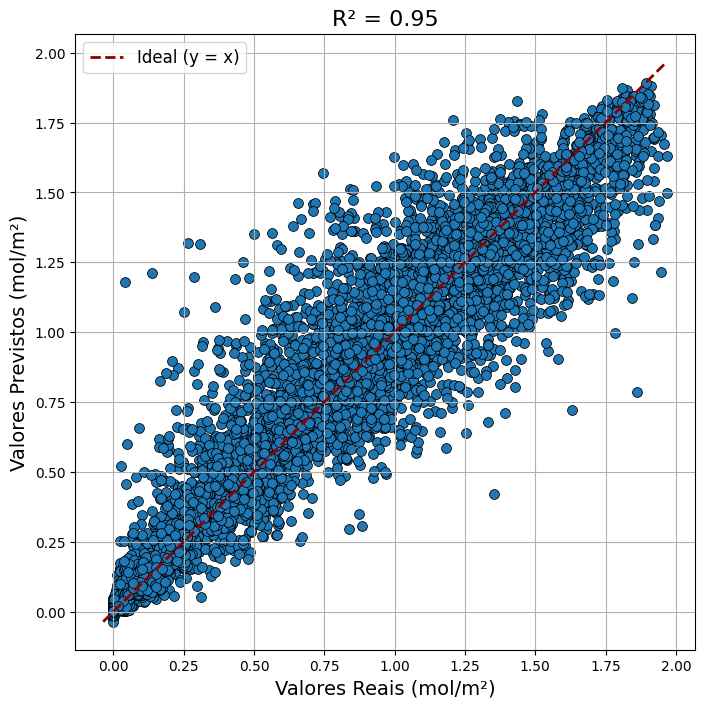

In [ ]:
import seaborn as sns

# Calcular o R²
r2_h2_xgboost = r2_score(n_h2_test_xgboost, n_h2_pred_xgboost)

# Criar o gráfico de dispersão
plt.figure(figsize=(8, 8))
# sns.scatterplot(x=n_h2_test, y=n_h2_pred, s=50, color='blue', edgecolor='k')
sns.scatterplot(x=n_h2_test_xgboost, y=n_h2_pred_xgboost, s=50, edgecolor='k')

# Linha de referência (y = x)
max_val = max(max(n_h2_test_xgboost), max(n_h2_pred_xgboost))
min_val = min(min(n_h2_test_xgboost), min(n_h2_pred_xgboost))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='darkred', linewidth=2, label='Ideal (y = x)')

# Personalização
plt.xlabel('Valores Reais (mol/m²)', fontsize=14)
plt.ylabel('Valores Previstos (mol/m²)', fontsize=14)
plt.title(f'R² = {r2_h2_xgboost:.2f}', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# LSTM

In [ ]:
# Divisão sequencial para validação
train_size = int(len(X_train_lstm) * 0.8)  # 80% treino, 20% validação
X_train_seq, X_val_seq = X_train_lstm[:train_size], X_train_lstm[train_size:]
y_train_seq, y_val_seq = y_train_lstm[:train_size], y_train_lstm[train_size:]

# a. Fit do modelo
history_random_search = lstm_model_instance.fit(
    X_train_lstm, y_train_lstm,
    batch_size=hyperparameters["LSTM"]["batch_size"],
    epochs=hyperparameters["LSTM"]["epochs"],
    validation_data=(X_val_seq, y_val_seq),
    verbose=2
)

Epoch 1/50
959/959 - 28s - 29ms/step - loss: 0.0181 - val_loss: 0.0121
Epoch 2/50
959/959 - 40s - 41ms/step - loss: 0.0113 - val_loss: 0.0097
Epoch 3/50
959/959 - 41s - 43ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 4/50
959/959 - 22s - 23ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 5/50
959/959 - 42s - 43ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 6/50
959/959 - 41s - 43ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 7/50
959/959 - 21s - 22ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 8/50
959/959 - 41s - 42ms/step - loss: 0.0078 - val_loss: 0.0081
Epoch 9/50
959/959 - 42s - 43ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 10/50
959/959 - 41s - 43ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 11/50
959/959 - 41s - 42ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 12/50
959/959 - 41s - 43ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 13/50
959/959 - 41s - 43ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 14/50
959/959 - 41s - 42ms/step - loss: 0.0069 - val_loss: 0.0066
E

In [ ]:
lstm_model_instance.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 32)              │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,421 (157.90 KB)

 Trainable params: 13,473 (52.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,948 (105.27 KB)

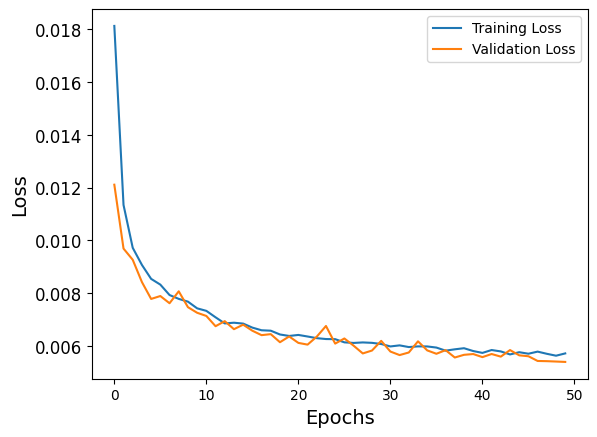

In [ ]:
# plot da loss
plt.plot(
    lstm_model_instance.history.history['loss'],
    label='Training Loss'
)
plt.plot(
    lstm_model_instance.history.history['val_loss'],
    label='Validation Loss'
)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
# plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# 📌 b. Fazer previsões
y_pred_lstm = lstm_model_instance.predict(X_test_lstm)

411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [ ]:
# 📌 c. Inverter o Min-Max Scaling
y_pred_inversed_lstm = scaler_Y_lstm.inverse_transform(y_pred_lstm.reshape(-1, 1)).ravel()
y_test_inversed_lstm = scaler_Y_lstm.inverse_transform(Y_ts_scaled.reshape(-1, 1)).ravel()
# y_pred_inversed_rf = scaler_Y_lstm.inverse_transform(y_pred_rf)
# y_test_inversed_rf = scaler_Y_lstm.inverse_transform(Y_ts_scaled)

In [ ]:
# 📌 d. Calcular as métricas
mae_lstm = mean_absolute_error(y_test_inversed_lstm, y_pred_inversed_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inversed_lstm, y_pred_inversed_lstm))
r2_lstm = r2_score(y_test_inversed_lstm, y_pred_inversed_lstm)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}, R²: {r2_lstm:.4f}")

Random Forest - MAE: 174.8366, RMSE: 320.1256, R²: 0.9190


In [ ]:
# Converter o array em Series com o mesmo índice de X_ts_top
y_test_inv_series_lstm = pd.Series(y_test_inversed_lstm.flatten(), index=X_ts_top.index)
y_pred_inv_series_lstm = pd.Series(y_pred_inversed_lstm.flatten(), index=X_ts_top.index)

In [ ]:
# Transformação em Qtde de H2 produzida
eta_fv = 0.22
eta_pc = 0.85

eta_ele = 0.755
hhv_h2 = 285.83   # kJ/mol

E_fv_test_lstm = y_test_inv_series_lstm * eta_fv * eta_pc   # Energia produzida em kJ/m2
E_fv_pred_lstm = y_pred_inv_series_lstm * eta_fv * eta_pc   # Energia produzida em kJ/m2

n_h2_test_lstm = E_fv_test_lstm * eta_ele / hhv_h2   # kJ/m2 * mol / kJ ==> mol/m2
n_h2_pred_lstm = E_fv_pred_lstm * eta_ele / hhv_h2   # mol/m2

In [ ]:
# 📌 Calcular as métricas em unidade de H2 produzido
mae_h2_lstm = mean_absolute_error(n_h2_test_lstm, n_h2_pred_lstm)
rmse_h2_lstm = np.sqrt(mean_squared_error(n_h2_test_lstm, n_h2_pred_lstm))
r2_h2_lstm = r2_score(n_h2_test_lstm, n_h2_pred_lstm)

# 📌 e. Exibir os resultados
print(f"Random Forest - MAE: {mae_h2_lstm:.4f}, RMSE_svr: {rmse_h2_lstm:.4f}, R²: {r2_h2_lstm:.4f}")

Random Forest - MAE: 0.0864, RMSE_svr: 0.1581, R²: 0.9190


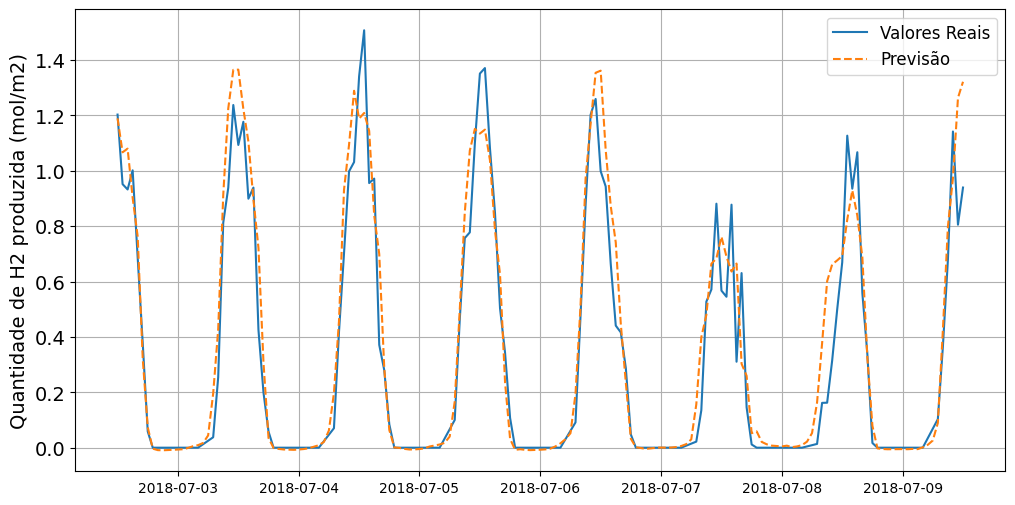

In [ ]:
# 📈 5. Plotar gráfico
# 7 dias
obs = 24 * 7

plt.figure(figsize=(12, 6))
plt.plot(n_h2_test_lstm[:obs+1], label='Valores Reais')
plt.plot(n_h2_pred_lstm[:obs+1], "--", label='Previsão')
# plt.title('Valores Reais vs Previsões (Random Forest)')
# plt.xlabel('Observações')
plt.ylabel('Quantidade de H2 produzida (mol/m2)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

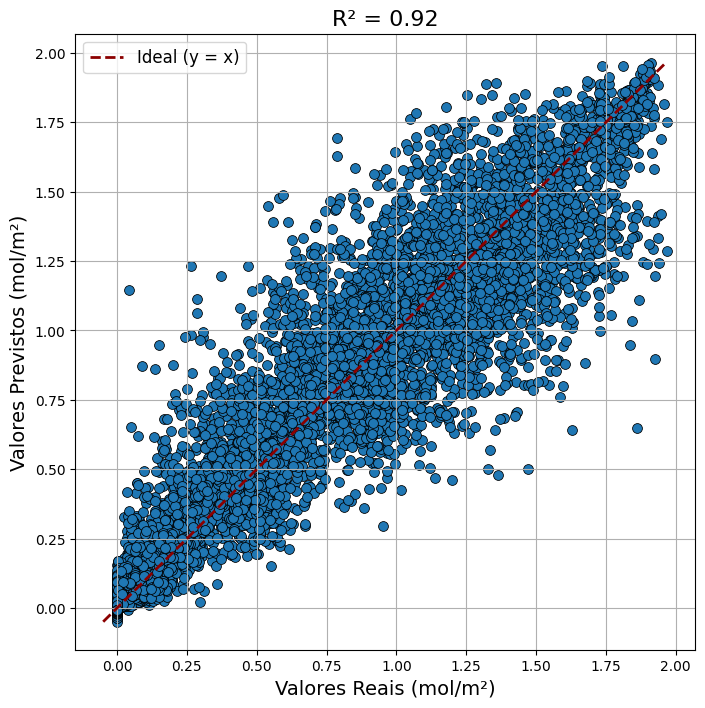

In [ ]:
import seaborn as sns

# Calcular o R²
r2_h2_lstm = r2_score(n_h2_test_lstm, n_h2_pred_lstm)

# Criar o gráfico de dispersão
plt.figure(figsize=(8, 8))
# sns.scatterplot(x=n_h2_test, y=n_h2_pred, s=50, color='blue', edgecolor='k')
sns.scatterplot(x=n_h2_test_lstm, y=n_h2_pred_lstm, s=50, edgecolor='k')

# Linha de referência (y = x)
max_val = max(max(n_h2_test_lstm), max(n_h2_pred_lstm))
min_val = min(min(n_h2_test_lstm), min(n_h2_pred_lstm))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='darkred', linewidth=2, label='Ideal (y = x)')

# Personalização
plt.xlabel('Valores Reais (mol/m²)', fontsize=14)
plt.ylabel('Valores Previstos (mol/m²)', fontsize=14)
plt.title(f'R² = {r2_h2_lstm:.2f}', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# Comparativo geral

<ipython-input-3-54085169a19b>:25: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())
<ipython-input-3-54085169a19b>:25: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())


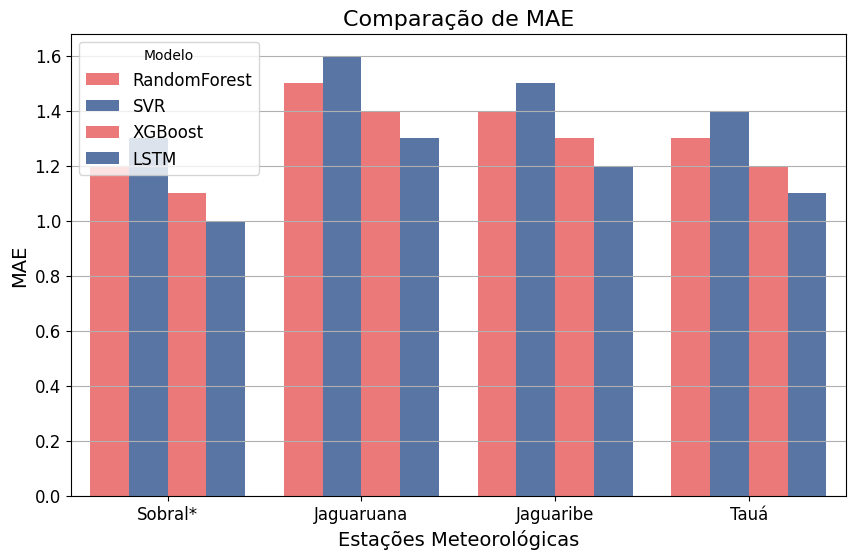

<ipython-input-3-54085169a19b>:25: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())
<ipython-input-3-54085169a19b>:25: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())


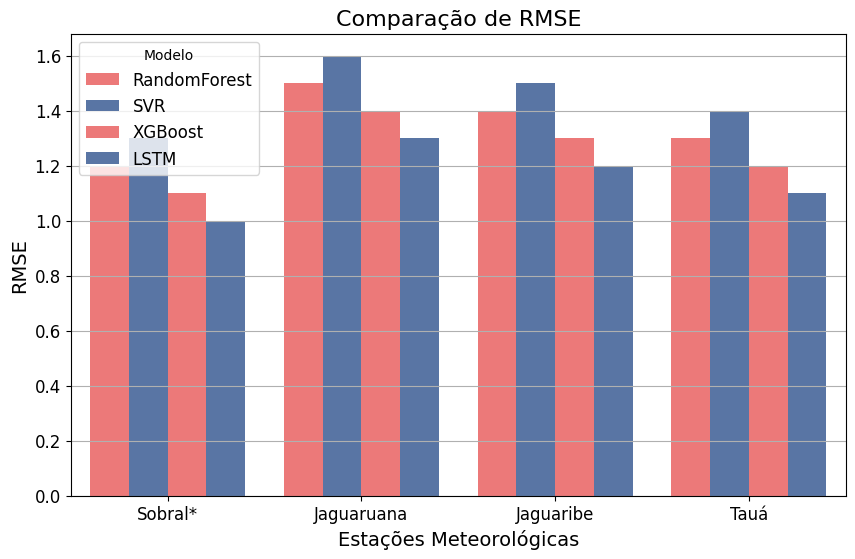

<ipython-input-3-54085169a19b>:25: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())
<ipython-input-3-54085169a19b>:25: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())


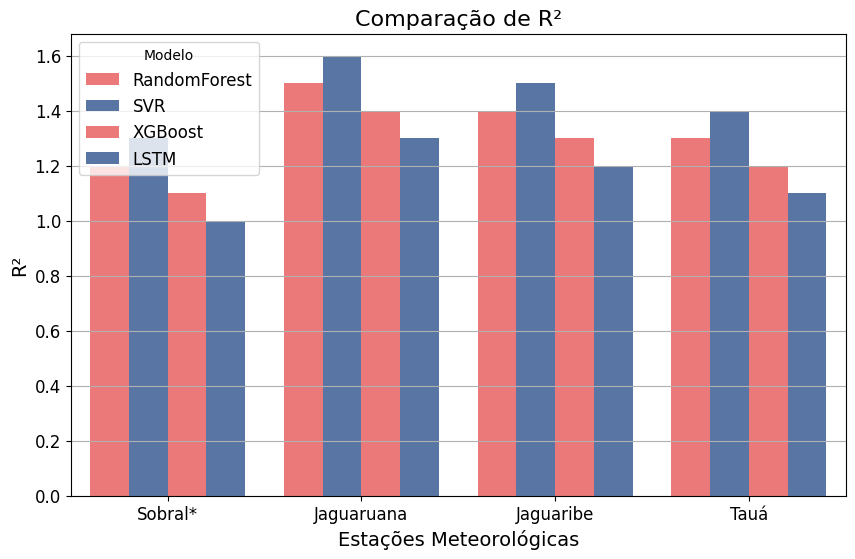

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dados de exemplo
resultados = {
    'Estação': ['Sobral', 'Jaguaruana', 'Jaguaribe', 'Tauá'],
    'RandomForest': [1.2, 1.5, 1.4, 1.3],
    'SVR': [1.3, 1.6, 1.5, 1.4],
    'XGBoost': [1.1, 1.4, 1.3, 1.2],
    'LSTM': [1.0, 1.3, 1.2, 1.1]
}

# Convertendo para DataFrame
df = pd.DataFrame(resultados)
df_melted = df.melt(id_vars='Estação', var_name='Modelo', value_name='Métrica')

# Destacar Sobral
df_melted['Cor'] = df_melted['Estação'].apply(lambda x: '#FF6666' if x == 'Sobral' else '#4C72B0')
df_melted['Estação'] = df_melted['Estação'].apply(lambda x: 'Sobral*' if x == 'Sobral' else x)

# Função para plotar
def plot_metric(df, metric_name):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())
    plt.ylabel(metric_name, fontsize=14)
    plt.xlabel('Estações Meteorológicas', fontsize=14)
    plt.title(f'Comparação de {metric_name}', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Modelo', fontsize=12)
    plt.grid(axis='y')
    plt.show()

# Gerar gráficos para MAE, RMSE e R²
plot_metric(df_melted, 'MAE')
plot_metric(df_melted, 'RMSE')
plot_metric(df_melted, 'R²')


<ipython-input-6-98c4d7b269e7>:32: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())


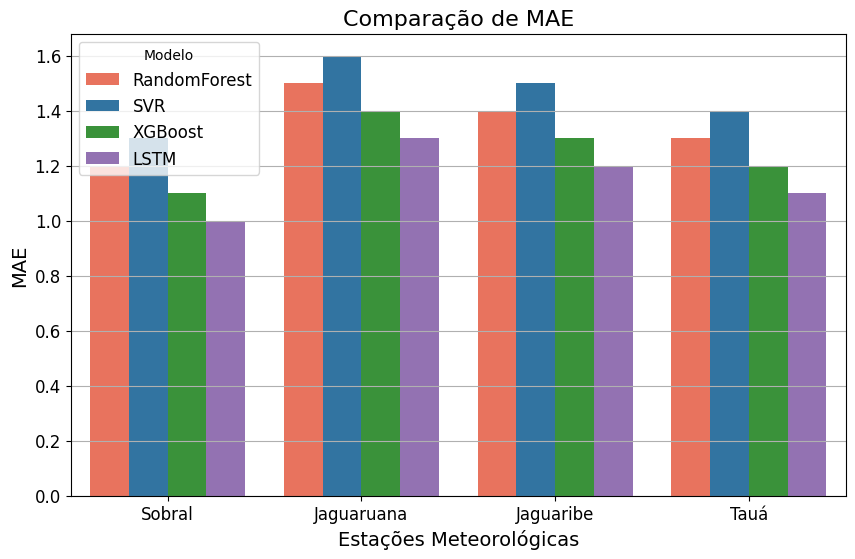

<ipython-input-6-98c4d7b269e7>:32: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())


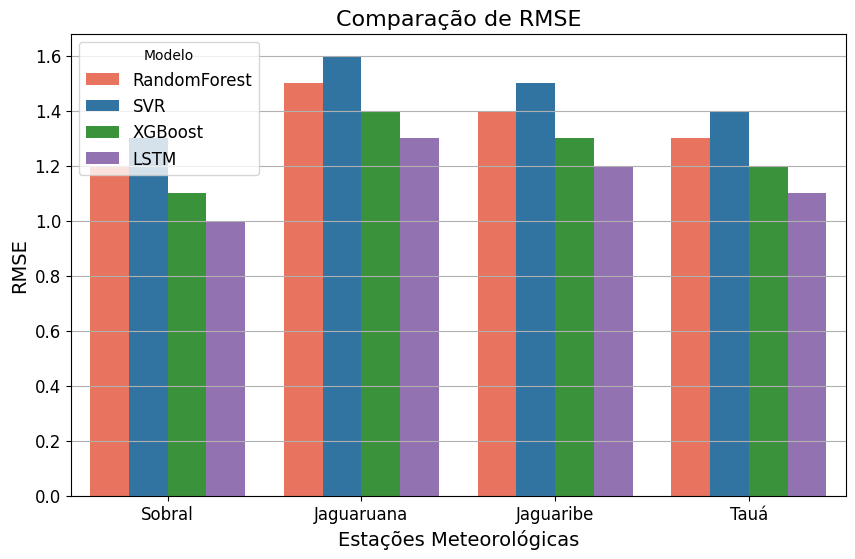

<ipython-input-6-98c4d7b269e7>:32: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())


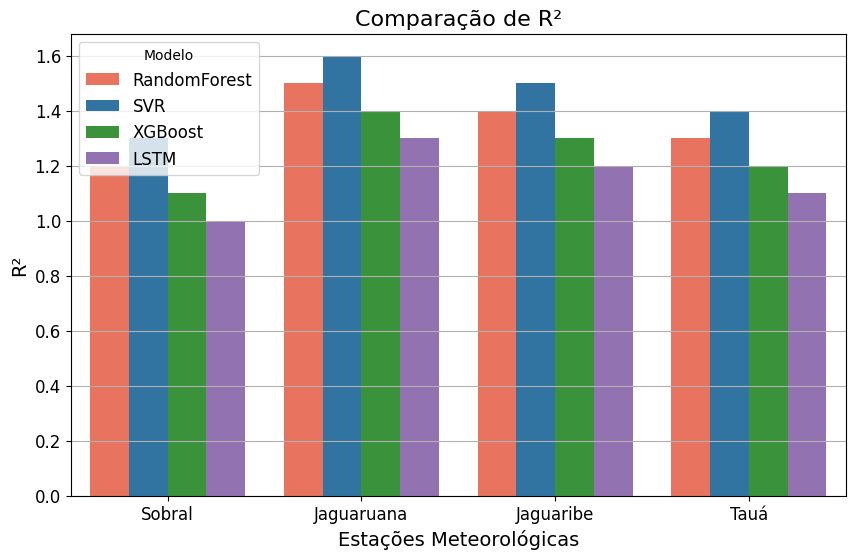

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dados de exemplo
resultados = {
    'Estação': ['Sobral', 'Jaguaruana', 'Jaguaribe', 'Tauá'],
    'RandomForest': [1.2, 1.5, 1.4, 1.3],
    'SVR': [1.3, 1.6, 1.5, 1.4],
    'XGBoost': [1.1, 1.4, 1.3, 1.2],
    'LSTM': [1.0, 1.3, 1.2, 1.1]
}

# Convertendo para DataFrame
df = pd.DataFrame(resultados)
df_melted = df.melt(id_vars='Estação', var_name='Modelo', value_name='Métrica')

# Definindo cores específicas para cada modelo
cor_modelo = {
    'RandomForest': '#FF6347',  # Tom vibrante de vermelho
    'SVR': '#1f77b4',          # Azul
    'XGBoost': '#2ca02c',       # Verde
    'LSTM': '#9467bd'           # Roxo
}

# Atribuindo as cores ao DataFrame
df_melted['Cor'] = df_melted['Modelo'].map(cor_modelo)

# Função para plotar
def plot_metric(df, metric_name):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())
    plt.ylabel(metric_name, fontsize=14)
    plt.xlabel('Estações Meteorológicas', fontsize=14)
    plt.title(f'Comparação de {metric_name}', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Modelo', fontsize=12)
    plt.grid(axis='y')
    plt.show()

# Gerar gráficos para MAE, RMSE e R²
plot_metric(df_melted, 'MAE')
plot_metric(df_melted, 'RMSE')
plot_metric(df_melted, 'R²')


<ipython-input-2-15e4c0984349>:61: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())


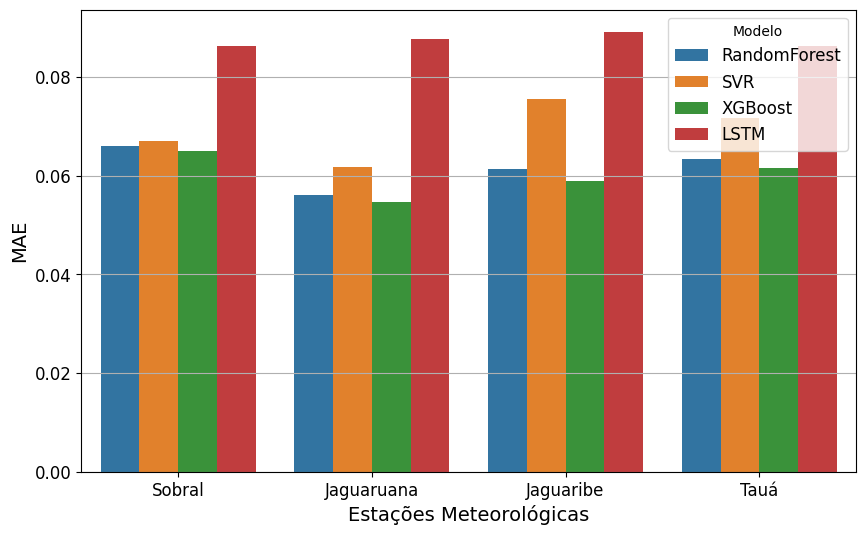

<ipython-input-2-15e4c0984349>:61: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())


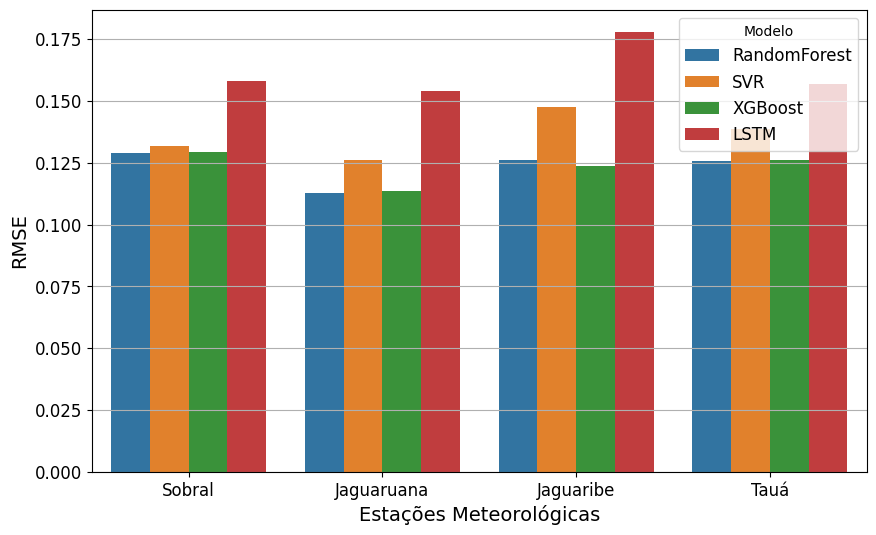

<ipython-input-2-15e4c0984349>:61: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())


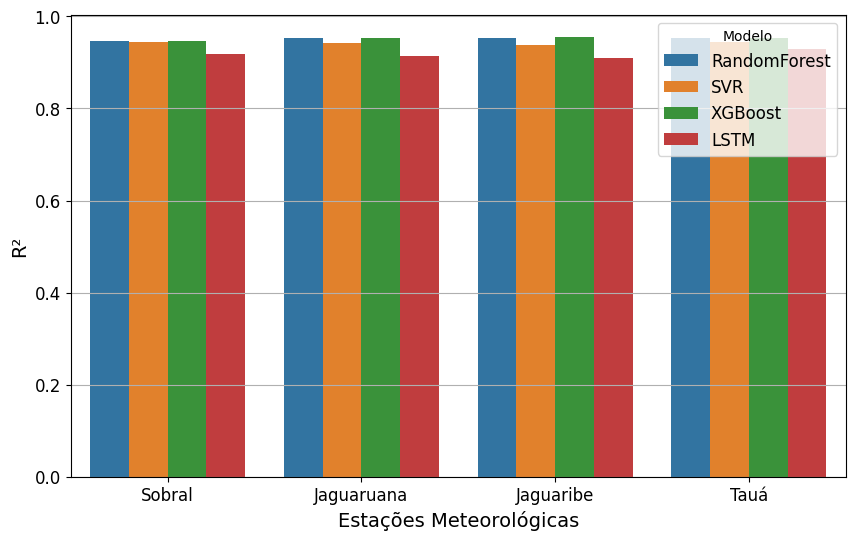

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dados de exemplo
resultados_mae = {
    'Estação': ['Sobral', 'Jaguaruana', 'Jaguaribe', 'Tauá'],
    'RandomForest': [0.0661, 0.0562, 0.0614, 0.0633],
    'SVR': [0.0670, 0.0617, 0.0756, 0.0718],
    'XGBoost': [0.0650, 0.0547, 0.0590, 0.0615],
    'LSTM': [0.0864, 0.0878, 0.0892, 0.0864]
}

resultados_rmse = {
    'Estação': ['Sobral', 'Jaguaruana', 'Jaguaribe', 'Tauá'],
    'RandomForest': [0.1290, 0.1129, 0.1261, 0.1258],
    'SVR': [0.1318, 0.1260, 0.1475, 0.1388],
    'XGBoost': [0.1294, 0.1134, 0.1237, 0.1260],
    'LSTM': [0.1581, 0.1541, 0.1780, 0.1567]
}

resultados_r2 = {
    'Estação': ['Sobral', 'Jaguaruana', 'Jaguaribe', 'Tauá'],
    'RandomForest': [0.9461, 0.9533, 0.9542, 0.9539],
    'SVR': [0.9437, 0.9420, 0.9373, 0.9439],
    'XGBoost': [0.9458, 0.9530, 0.9559, 0.9538],
    'LSTM': [0.9190, 0.9132, 0.9087, 0.9285]
}

# Convertendo para DataFrame
df_mae = pd.DataFrame(resultados_mae)
df_melted_mae = df_mae.melt(id_vars='Estação', var_name='Modelo', value_name='Métrica')

df_rmse = pd.DataFrame(resultados_rmse)
df_melted_rmse = df_rmse.melt(id_vars='Estação', var_name='Modelo', value_name='Métrica')

df_r2 = pd.DataFrame(resultados_r2)
df_melted_r2 = df_r2.melt(id_vars='Estação', var_name='Modelo', value_name='Métrica')

# Definindo cores da paleta tradicional do matplotlib (tab10)
cores = plt.cm.tab10.colors  # Utilizando as cores da paleta tab10
# cores = plt.cm.viridis.colors  # Utilizando as cores da paleta tab10


# Atribuindo cores específicas para cada modelo da paleta tab10
cor_modelo = {
    'RandomForest': cores[0],  # Primeira cor da paleta
    'SVR': cores[1],          # Segunda cor da paleta
    'XGBoost': cores[2],       # Terceira cor da paleta
    'LSTM': cores[3]           # Quarta cor da paleta
}

# Atribuindo as cores ao DataFrame
df_melted_mae['Cor'] = df_melted_mae['Modelo'].map(cor_modelo)
df_melted_rmse['Cor'] = df_melted_rmse['Modelo'].map(cor_modelo)
df_melted_r2['Cor'] = df_melted_r2['Modelo'].map(cor_modelo)

# Função para plotar
def plot_metric(df, metric_name):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Estação', y='Métrica', hue='Modelo', palette=df['Cor'].unique())
    plt.ylabel(metric_name, fontsize=14)
    plt.xlabel('Estações Meteorológicas', fontsize=14)
    # plt.title(f'Comparação de {metric_name}', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Modelo', fontsize=12)
    plt.grid(axis='y')
    plt.show()

# Gerar gráficos para MAE, RMSE e R²
plot_metric(df_melted_mae, 'MAE')
plot_metric(df_melted_rmse, 'RMSE')
plot_metric(df_melted_r2, 'R²')


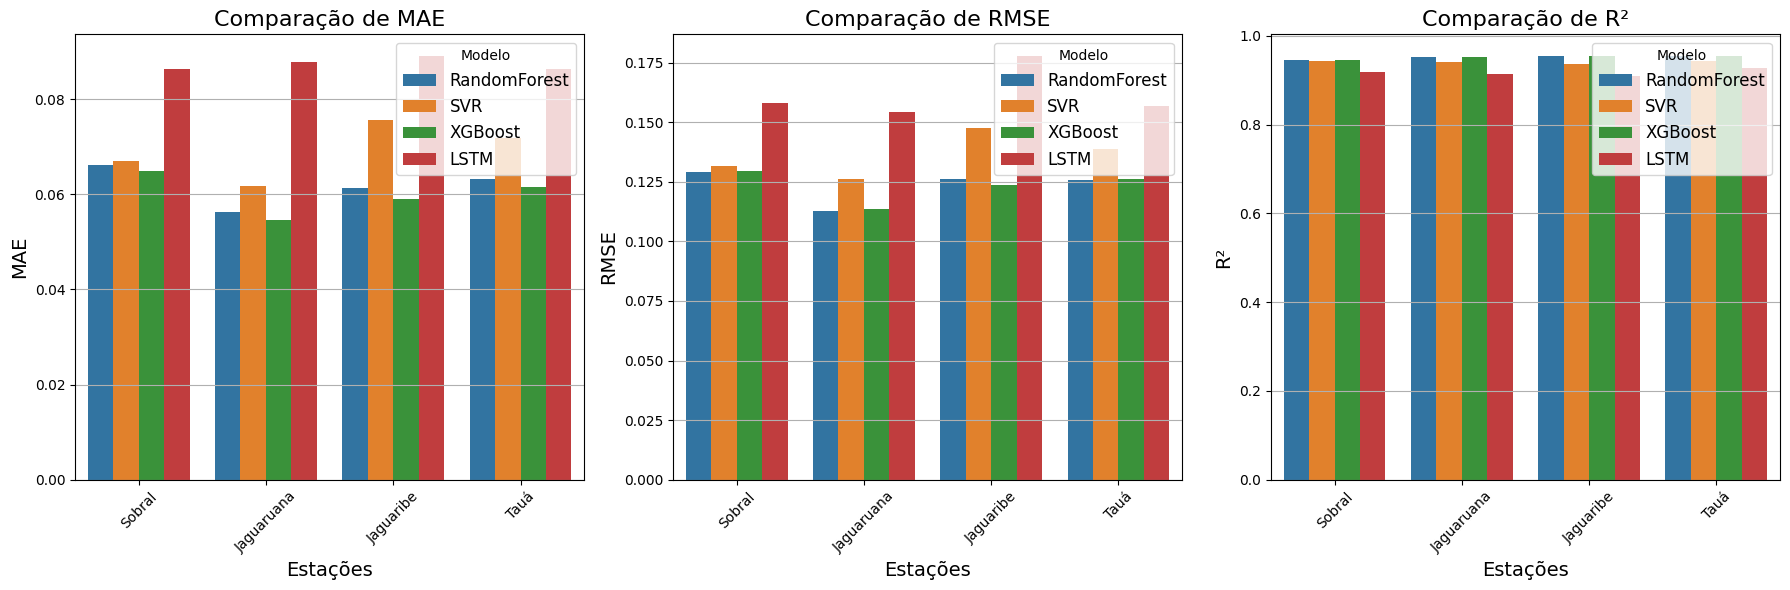

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dados de exemplo
resultados_mae = {
    'Estação': ['Sobral', 'Jaguaruana', 'Jaguaribe', 'Tauá'],
    'RandomForest': [0.0661, 0.0562, 0.0614, 0.0633],
    'SVR': [0.0670, 0.0617, 0.0756, 0.0718],
    'XGBoost': [0.0650, 0.0547, 0.0590, 0.0615],
    'LSTM': [0.0864, 0.0878, 0.0892, 0.0864]
}

resultados_rmse = {
    'Estação': ['Sobral', 'Jaguaruana', 'Jaguaribe', 'Tauá'],
    'RandomForest': [0.1290, 0.1129, 0.1261, 0.1258],
    'SVR': [0.1318, 0.1260, 0.1475, 0.1388],
    'XGBoost': [0.1294, 0.1134, 0.1237, 0.1260],
    'LSTM': [0.1581, 0.1541, 0.1780, 0.1567]
}

resultados_r2 = {
    'Estação': ['Sobral', 'Jaguaruana', 'Jaguaribe', 'Tauá'],
    'RandomForest': [0.9461, 0.9533, 0.9542, 0.9539],
    'SVR': [0.9437, 0.9420, 0.9373, 0.9439],
    'XGBoost': [0.9458, 0.9530, 0.9559, 0.9538],
    'LSTM': [0.9190, 0.9132, 0.9087, 0.9285]
}

# Convertendo para DataFrame
df_mae = pd.DataFrame(resultados_mae).melt(id_vars='Estação', var_name='Modelo', value_name='Métrica')
df_rmse = pd.DataFrame(resultados_rmse).melt(id_vars='Estação', var_name='Modelo', value_name='Métrica')
df_r2 = pd.DataFrame(resultados_r2).melt(id_vars='Estação', var_name='Modelo', value_name='Métrica')

# Definindo cores da paleta tab10
cores = plt.cm.tab10.colors

# Mapeamento de cores por modelo
cor_modelo = {
    'RandomForest': cores[0],
    'SVR': cores[1],
    'XGBoost': cores[2],
    'LSTM': cores[3]
}

# Criando figura com 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Função para plotar
def plot_metric(ax, df, metric_name):
    sns.barplot(ax=ax, data=df, x='Estação', y='Métrica', hue='Modelo', palette=cor_modelo)
    ax.set_ylabel(metric_name, fontsize=14)
    ax.set_xlabel('Estações', fontsize=14)
    ax.set_title(f'Comparação de {metric_name}', fontsize=16)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y')
    ax.legend(title='Modelo', fontsize=12)

# Criando os três gráficos
plot_metric(axes[0], df_mae, 'MAE')
plot_metric(axes[1], df_rmse, 'RMSE')
plot_metric(axes[2], df_r2, 'R²')

plt.tight_layout()
plt.show()


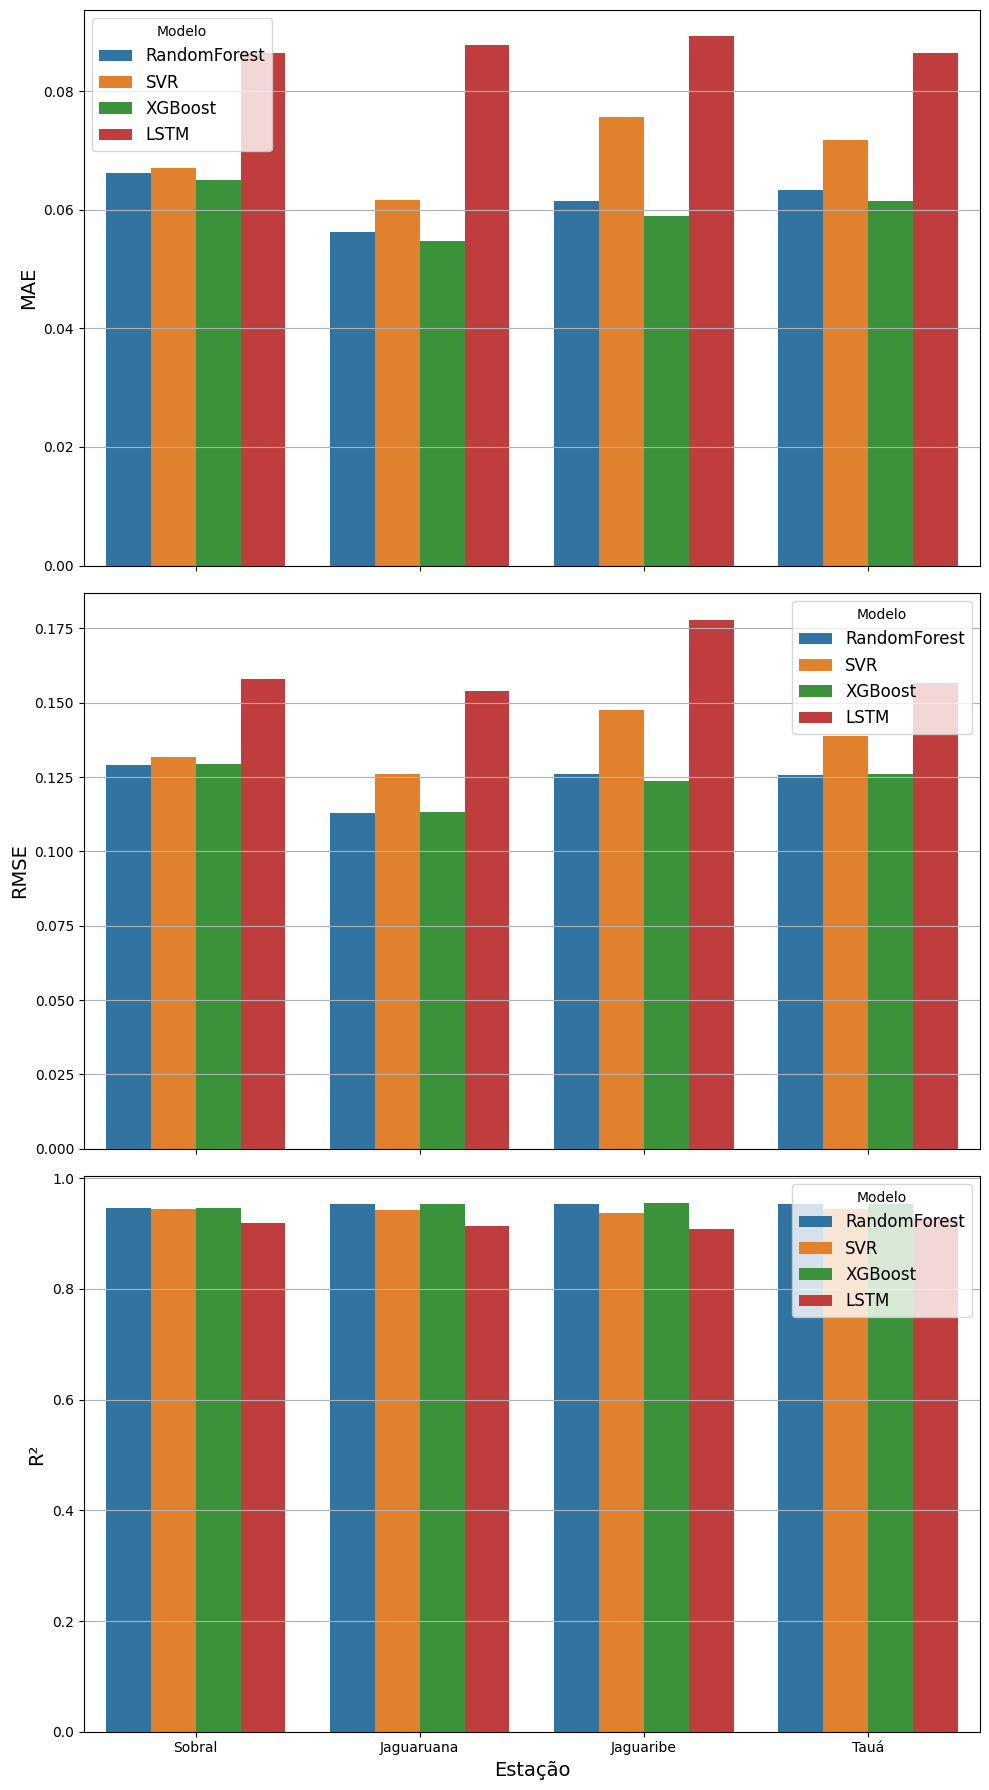

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dados de exemplo
resultados_mae = {
    'Estação': ['Sobral', 'Jaguaruana', 'Jaguaribe', 'Tauá'],
    'RandomForest': [0.0661, 0.0562, 0.0614, 0.0633],
    'SVR': [0.0670, 0.0617, 0.0756, 0.0718],
    'XGBoost': [0.0650, 0.0547, 0.0590, 0.0615],
    'LSTM': [0.0864, 0.0878, 0.0892, 0.0864]
}

resultados_rmse = {
    'Estação': ['Sobral', 'Jaguaruana', 'Jaguaribe', 'Tauá'],
    'RandomForest': [0.1290, 0.1129, 0.1261, 0.1258],
    'SVR': [0.1318, 0.1260, 0.1475, 0.1388],
    'XGBoost': [0.1294, 0.1134, 0.1237, 0.1260],
    'LSTM': [0.1581, 0.1541, 0.1780, 0.1567]
}

resultados_r2 = {
    'Estação': ['Sobral', 'Jaguaruana', 'Jaguaribe', 'Tauá'],
    'RandomForest': [0.9461, 0.9533, 0.9542, 0.9539],
    'SVR': [0.9437, 0.9420, 0.9373, 0.9439],
    'XGBoost': [0.9458, 0.9530, 0.9559, 0.9538],
    'LSTM': [0.9190, 0.9132, 0.9087, 0.9285]
}

# Convertendo para DataFrame
df_mae = pd.DataFrame(resultados_mae).melt(id_vars='Estação', var_name='Modelo', value_name='Métrica')
df_rmse = pd.DataFrame(resultados_rmse).melt(id_vars='Estação', var_name='Modelo', value_name='Métrica')
df_r2 = pd.DataFrame(resultados_r2).melt(id_vars='Estação', var_name='Modelo', value_name='Métrica')

# Definindo cores da paleta tab10
cores = plt.cm.tab10.colors

# Mapeamento de cores por modelo
cor_modelo = {
    'RandomForest': cores[0],
    'SVR': cores[1],
    'XGBoost': cores[2],
    'LSTM': cores[3]
}

# Criando figura com 3 subplots na vertical
fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

# Função para plotar
def plot_metric(ax, df, metric_name):
    sns.barplot(ax=ax, data=df, x='Estação', y='Métrica', hue='Modelo', palette=cor_modelo)
    ax.set_ylabel(metric_name, fontsize=14)
    ax.set_xlabel('Estação', fontsize=14)
    # ax.set_title(f'Comparação de {metric_name}', fontsize=16)
    ax.grid(axis='y')
    ax.legend(title='Modelo', fontsize=12)

# Criando os três gráficos
plot_metric(axes[0], df_mae, 'MAE')
plot_metric(axes[1], df_rmse, 'RMSE')
plot_metric(axes[2], df_r2, 'R²')

plt.tight_layout()
plt.show()
